In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [2]:
# Konfigurasi database sumber
source_cred = credentials.Certificate("D:/staklimjerukagung-firebase-adminsdk-kcfma-e091165a9b.json")
firebase_admin.initialize_app(source_cred, {
    'databaseURL': 'https://staklimjerukagung-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

In [3]:
# Input readable date
start_readable_date = "01-10-2025 00:00:00"  # Format: DD-MM-YYYY HH:MM:SS
end_readable_date = "01-11-2025 23:59:59"  # Format: DD-MM-YYYY HH:MM:SS

# Convert readable date to Unix timestamp
start_timestamp = int(datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(start_timestamp) # Convert to string and print
end_timestamp = int(datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(end_timestamp) # Convert to string and print


1759251600
1762016399


In [4]:
def fetch_weather_data(station_id, start_ts, end_ts):
    """
    Mengambil data cuaca dari Firebase Realtime Database untuk stasiun dan rentang waktu tertentu.

    Args:
        station_id (str): ID stasiun cuaca (contoh: 'id-03', 'id-04').
        start_ts (int): Timestamp awal (epoch time).
        end_ts (int): Timestamp akhir (epoch time).

    Returns:
        dict: Hasil data dari Firebase, atau None jika tidak ada data.
    """
    try:
        # Membuat path referensi secara dinamis berdasarkan station_id
        ref_path = f'/auto_weather_stat/{station_id}/data'
        ref_data = db.reference(ref_path)

        # Membuat query dengan rentang waktu
        query_data = ref_data.order_by_key().start_at(str(start_ts)).end_at(str(end_ts))

        # Mengambil dan mengembalikan hasil
        results = query_data.get()
        print(f"Data untuk stasiun {station_id} berhasil diambil.")
        return results
    except Exception as e:
        print(f"Terjadi error saat mengambil data untuk {station_id}: {e}")
        return None

# 2. Siapkan daftar ID stasiun yang ingin diambil datanya
station_ids = ['id-03', 'id-05'] # Mudah untuk menambah stasiun baru

# 3. Gunakan loop untuk mengambil data semua stasiun dan simpan hasilnya
all_weather_data = {}
for station in station_ids:
    # Panggil fungsi untuk setiap stasiun
    data = fetch_weather_data(station, start_timestamp, end_timestamp)
    if data:
        all_weather_data[station] = data

Data untuk stasiun id-03 berhasil diambil.
Data untuk stasiun id-05 berhasil diambil.


In [5]:
def create_weather_dataframe(data_dict, source_name):
    """
    Mengubah dictionary data cuaca menjadi DataFrame Pandas.

    Args:
        data_dict (dict): Dictionary berisi data cuaca yang diambil dari Firebase.
        source_name (str): Nama atau ID sumber data untuk keperluan logging/print.

    Returns:
        pandas.DataFrame: DataFrame yang sudah diformat, atau None jika input kosong.
    """
    # Periksa apakah ada data untuk diproses
    if not data_dict:
        print(f"Tidak ada data dari sumber '{source_name}' untuk diproses.")
        return None

    try:
        # Mengubah data dari dictionary menjadi DataFrame
        # 'orient="index"' menjadikan key dari dictionary sebagai baris awal
        df = pd.DataFrame.from_dict(data_dict, orient='index')

        # Memastikan kolom 'timestamp' ada.
        # Jika 'timestamp' bukan salah satu kolom, berarti ia adalah indeks.
        if 'timestamp' not in df.columns:
            df.index.name = 'timestamp'  # Beri nama pada indeks
            df.reset_index(inplace=True) # Pindahkan indeks menjadi kolom biasa

        print(f"DataFrame untuk sumber '{source_name}' berhasil dibuat.")
        return df
        
    except Exception as e:
        print(f"Gagal membuat DataFrame untuk '{source_name}': {e}")
        return None


# 2. Siapkan dictionary kosong untuk menampung DataFrame yang akan kita buat
weather_dataframes = {}

# 3. Loop melalui setiap item di all_weather_data
#    Gunakan .items() untuk mendapatkan key (nama stasiun) dan value (datanya)
for station_id, raw_data in all_weather_data.items():
    
    # Panggil fungsi baru kita untuk mengubah data mentah menjadi DataFrame
    df = create_weather_dataframe(raw_data, station_id)
    
    # Jika DataFrame berhasil dibuat, simpan ke dalam dictionary kita
    if df is not None:
        weather_dataframes[station_id] = df

# 4. Sekarang semua DataFrame Anda tersimpan rapi di satu tempat
print("\n--- Verifikasi Hasil ---")

DataFrame untuk sumber 'id-03' berhasil dibuat.
DataFrame untuk sumber 'id-05' berhasil dibuat.

--- Verifikasi Hasil ---


In [6]:
if 'id-03' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-03':")
    print(weather_dataframes['id-03'].head())

if 'id-04' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-04':")
    print(weather_dataframes['id-04'].head())

if 'id-05' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-05':")
    print(weather_dataframes['id-05'].head())


Menampilkan 5 baris pertama dari DataFrame 'id-03':
                 dew  humidity  pressure  temperature   timestamp  volt
1759251613  24.70950     98.81   1012.30        24.91  1759251613  4.09
1759251673  24.72439     98.78   1012.29        24.93  1759251673  4.09
1759251733  24.73437     98.78   1012.27        24.94  1759251733  4.09
1759251793  24.72608     98.79   1012.24        24.93  1759251793  4.09
1759251853  24.70611     98.79   1012.25        24.91  1759251853  4.09

Menampilkan 5 baris pertama dari DataFrame 'id-05':
                 dew  humidity  pressure  rainfall  rainrate  temperature  \
1759251627  25.00029  94.89647   1011.43    6.7056       0.0     25.88388   
1759251687  24.99310  94.93080   1011.44    6.7056       0.0     25.87053   
1759251747  25.01143  94.95941   1011.44    6.7056       0.0     25.88388   
1759251807  25.01032  95.02808   1011.40    6.7056       0.0     25.87053   
1759251867  24.98992  94.97276   1011.40    6.7056       0.0     25.85985   


In [7]:
def convert_timestamp_to_int(df, column_name='timestamp'):
    """
    Mengubah tipe data kolom tertentu dalam DataFrame menjadi integer.

    Args:
        df (pd.DataFrame): DataFrame yang akan dimodifikasi.
        column_name (str): Nama kolom yang akan diubah tipenya. Defaultnya adalah 'timestamp'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi, atau DataFrame asli jika kolom tidak ditemukan.
    """
    # Periksa apakah input adalah DataFrame yang valid dan memiliki kolom yang dimaksud
    if isinstance(df, pd.DataFrame) and column_name in df.columns:
        try:
            df[column_name] = df[column_name].astype(int)
            print(f"Kolom '{column_name}' berhasil diubah menjadi tipe integer.")
        except Exception as e:
            print(f"Gagal mengubah tipe data kolom '{column_name}': {e}")
    else:
        # Memberi tahu pengguna jika kolom tidak ada di DataFrame
        print(f"Peringatan: Kolom '{column_name}' tidak ditemukan dalam DataFrame.")
        
    return df



In [8]:
# Loop melalui setiap DataFrame dan terapkan fungsi konversi
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = convert_timestamp_to_int(weather_dataframes[station_id])

print("\n--- Memeriksa tipe data SETELAH konversi ---")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diubah menjadi tipe integer.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diubah menjadi tipe integer.

--- Memeriksa tipe data SETELAH konversi ---


In [9]:
def format_datetime_column(df, column_name='timestamp', target_tz='Asia/Jakarta'):
    """
    Mengonversi kolom timestamp (integer) ke datetime dengan zona waktu tertentu.

    Proses:
    1. Mengubah integer timestamp (detik) menjadi datetime dalam UTC.
    2. Mengonversi datetime dari UTC ke zona waktu target (default: 'Asia/Jakarta').

    Args:
        df (pd.DataFrame): DataFrame yang akan diproses.
        column_name (str): Nama kolom timestamp. Defaultnya 'timestamp'.
        target_tz (str): Zona waktu target. Defaultnya 'Asia/Jakarta'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi.
    """
    # Pastikan input adalah DataFrame dan kolomnya ada
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Konversi dari integer (epoch seconds) ke datetime UTC
        df[column_name] = pd.to_datetime(df[column_name], unit='s', utc=True)
        
        # Langkah 2: Konversi zona waktu dari UTC ke target_tz (WIB)
        df[column_name] = df[column_name].dt.tz_convert(target_tz)
        
        print(f"Kolom '{column_name}' berhasil diformat ke zona waktu {target_tz}.")
    except Exception as e:
        print(f"Gagal memformat kolom '{column_name}': {e}")
        
    return df

In [10]:
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = format_datetime_column(weather_dataframes[station_id])

print("\n" + "="*40 + "\n")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.




In [11]:
def add_time_features(df, column_name='timestamp'):
    """
    Menambahkan kolom-kolom berbasis waktu (jam, hari, bulan, dll.) ke DataFrame.

    Proses:
    1. Memastikan kolom waktu berformat datetime.
    2. Mengurutkan DataFrame berdasarkan kolom waktu tersebut.
    3. Mengekstrak dan menambahkan kolom 'hour', 'minute', 'day', 'week', 'month', dan 'year'.

    Args:
        df (pd.DataFrame): DataFrame input.
        column_name (str): Nama kolom datetime yang akan diproses.

    Returns:
        pd.DataFrame: DataFrame baru dengan kolom-kolom waktu tambahan.
    """
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Memastikan kolom 'timestamp' berformat datetime (sebagai pengaman)
        df[column_name] = pd.to_datetime(df[column_name])

        # Langkah 2: Mengurutkan data berdasarkan 'timestamp'
        df = df.sort_values(by=column_name)

        # Langkah 3: Menambahkan kolom-kolom waktu
        df['hour'] = df[column_name].dt.hour
        df['minute'] = df[column_name].dt.minute
        df['day'] = df[column_name].dt.day
        df['week'] = df[column_name].dt.isocalendar().week.astype(int) # .isocalendar() menghasilkan object kompleks
        df['month'] = df[column_name].dt.month
        df['year'] = df[column_name].dt.year
        
        print(f"Fitur waktu berhasil ditambahkan ke DataFrame.")
    except Exception as e:
        print(f"Gagal menambahkan fitur waktu: {e}")
        
    return df

In [12]:
for station_id in weather_dataframes:
    print(f"--- Memproses DataFrame untuk stasiun: {station_id} ---")
    weather_dataframes[station_id] = add_time_features(weather_dataframes[station_id])

print("\n" + "="*50 + "\n")

# Verifikasi hasil dari dictionary
print("Hasil akhir untuk 'id-03' dari dictionary:")
print(weather_dataframes['id-03'].head())

--- Memproses DataFrame untuk stasiun: id-03 ---
Fitur waktu berhasil ditambahkan ke DataFrame.
--- Memproses DataFrame untuk stasiun: id-05 ---
Fitur waktu berhasil ditambahkan ke DataFrame.


Hasil akhir untuk 'id-03' dari dictionary:
                 dew  humidity  pressure  temperature  \
1759251613  24.70950     98.81   1012.30        24.91   
1759251673  24.72439     98.78   1012.29        24.93   
1759251733  24.73437     98.78   1012.27        24.94   
1759251793  24.72608     98.79   1012.24        24.93   
1759251853  24.70611     98.79   1012.25        24.91   

                           timestamp  volt  hour  minute  day  week  month  \
1759251613 2025-10-01 00:00:13+07:00  4.09     0       0    1    40     10   
1759251673 2025-10-01 00:01:13+07:00  4.09     0       1    1    40     10   
1759251733 2025-10-01 00:02:13+07:00  4.09     0       2    1    40     10   
1759251793 2025-10-01 00:03:13+07:00  4.09     0       3    1    40     10   
1759251853 2025-10-01 00:04:13

In [13]:
# Mengekstrak setiap DataFrame ke variabel terpisah
cuaca1 = weather_dataframes['id-03']
#cuaca2 = weather_dataframes['id-04']
cuaca3 = weather_dataframes['id-05']

=== Informasi Missing Values dalam cuaca3 ===

dew            0
humidity       0
pressure       0
temperature    0
timestamp      0
volt           0
hour           0
minute         0
day            0
week           0
month          0
year           0
dtype: int64


=== Persentase Missing Values ===

dew            0.0
humidity       0.0
pressure       0.0
temperature    0.0
timestamp      0.0
volt           0.0
hour           0.0
minute         0.0
day            0.0
week           0.0
month          0.0
year           0.0
dtype: float64


=== Visualisasi Missing Values ===


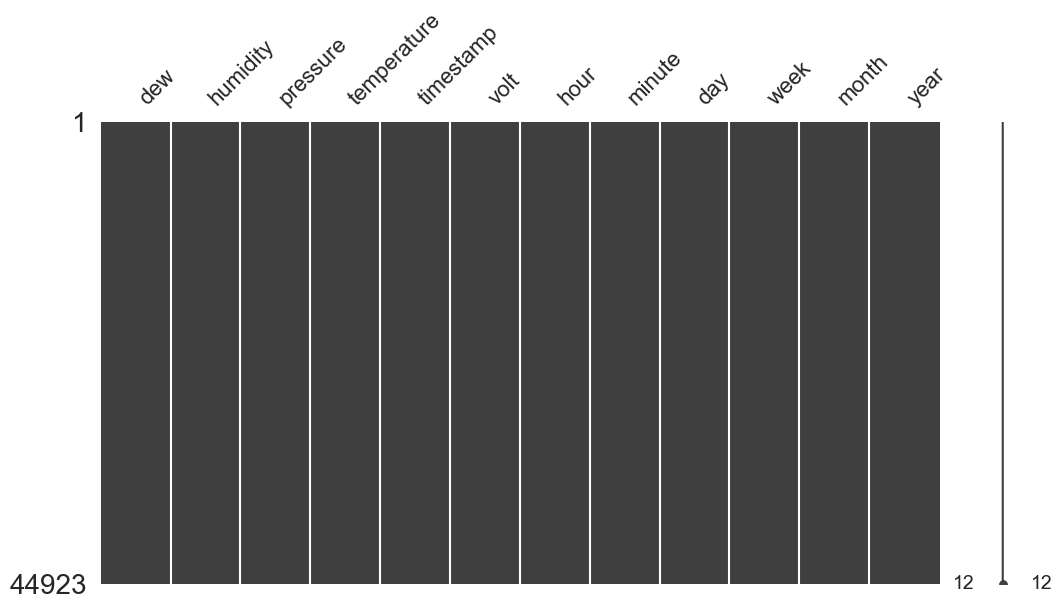


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 0

Contoh baris dengan null:
Empty DataFrame
Columns: [dew, humidity, pressure, temperature, timestamp, volt, hour, minute, day, week, month, year]
Index: []


In [14]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca1.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca1.isnull().sum() / len(cuaca1)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca1, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca1[cuaca1.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

=== Informasi Missing Values dalam cuaca3 ===

dew            0
humidity       0
pressure       0
rainfall       0
rainrate       0
temperature    0
timestamp      0
volt           0
hour           0
minute         0
day            0
week           0
month          0
year           0
dtype: int64


=== Persentase Missing Values ===

dew            0.0
humidity       0.0
pressure       0.0
rainfall       0.0
rainrate       0.0
temperature    0.0
timestamp      0.0
volt           0.0
hour           0.0
minute         0.0
day            0.0
week           0.0
month          0.0
year           0.0
dtype: float64


=== Visualisasi Missing Values ===


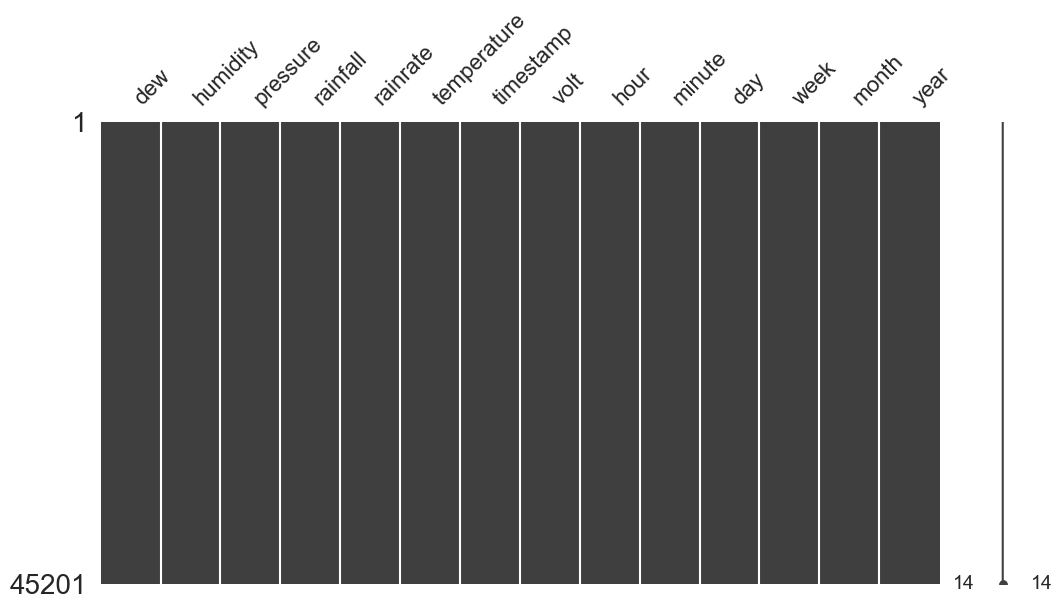


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 0

Contoh baris dengan null:
Empty DataFrame
Columns: [dew, humidity, pressure, rainfall, rainrate, temperature, timestamp, volt, hour, minute, day, week, month, year]
Index: []


In [15]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca3.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca3.isnull().sum() / len(cuaca3)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca3, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca3[cuaca3.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

In [16]:
def plot_station_trends(data_dict, column_to_plot, freq='d'):
    """
    Membuat plot tren perbandingan untuk sebuah kolom dari beberapa stasiun cuaca.

    Args:
        data_dict (dict): Dictionary yang berisi {station_id: DataFrame}.
        column_to_plot (str): Nama kolom yang akan di-plot (misal: 'temperature').
        freq (str): Frekuensi untuk pengelompokan data.
                    'd' untuk harian (daily).
                    'h' untuk per jam (hourly).
    """
    # Menentukan label berdasarkan frekuensi
    freq_labels = {
        'd': {'label': 'Harian', 'xlabel': 'Tanggal'},
        'h': {'label': 'Per Jam', 'xlabel': 'Waktu (Jam)'},
        'min': {'label': 'Per Menit', 'xlabel': 'Waktu (Menit)'}
    }
    
    # Pilih label yang sesuai, default ke 'Harian' jika freq tidak dikenali
    selected_freq = freq_labels.get(freq, freq_labels['d'])
    
    # Membuat figure dan axes untuk plot
    plt.figure(figsize=(15, 7))

    # Loop melalui setiap stasiun dalam dictionary
    for station_id, df in data_dict.items():
        if column_to_plot not in df.columns:
            print(f"Peringatan: Kolom '{column_to_plot}' tidak ada di stasiun {station_id}. Dilewati.")
            continue

        temp_df = df.copy()
        
        # Mengelompokkan data berdasarkan frekuensi (harian atau per jam)
        time_group_col = f'time_group_{freq}'
        temp_df[time_group_col] = temp_df['timestamp'].dt.floor(freq)
        trend_data = temp_df.groupby(time_group_col)[column_to_plot].mean().reset_index()

        # Plot data untuk stasiun saat ini
        plt.plot(trend_data[time_group_col], trend_data[column_to_plot], label=station_id, alpha=0.8)

    # Menambahkan detail pada plot
    plt.xlabel(selected_freq['xlabel'])
    plt.ylabel(f"Rata-rata {column_to_plot.capitalize()}")
    plt.title(f"Perbandingan Rata-rata {selected_freq['label']} {column_to_plot.capitalize()} antar Stasiun")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Menampilkan plot
    plt.show()

Menampilkan plot perbandingan per menit...


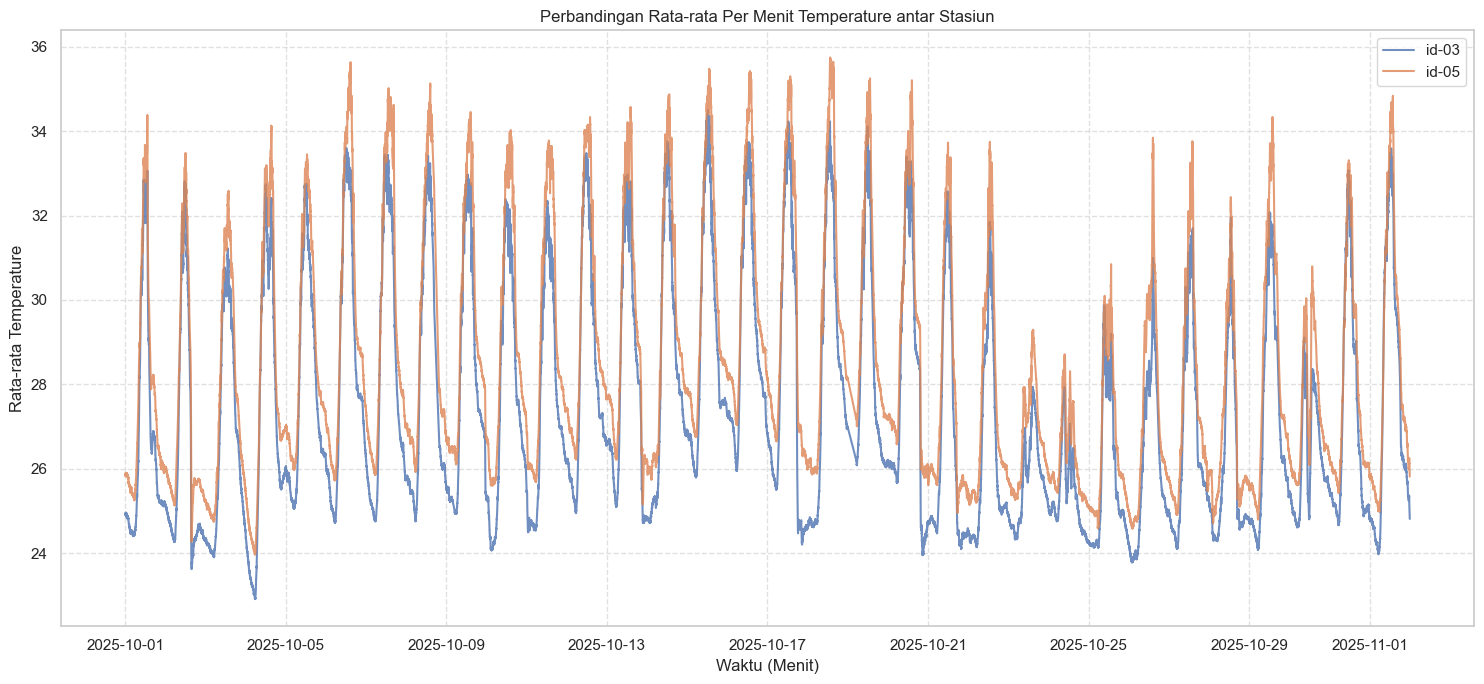

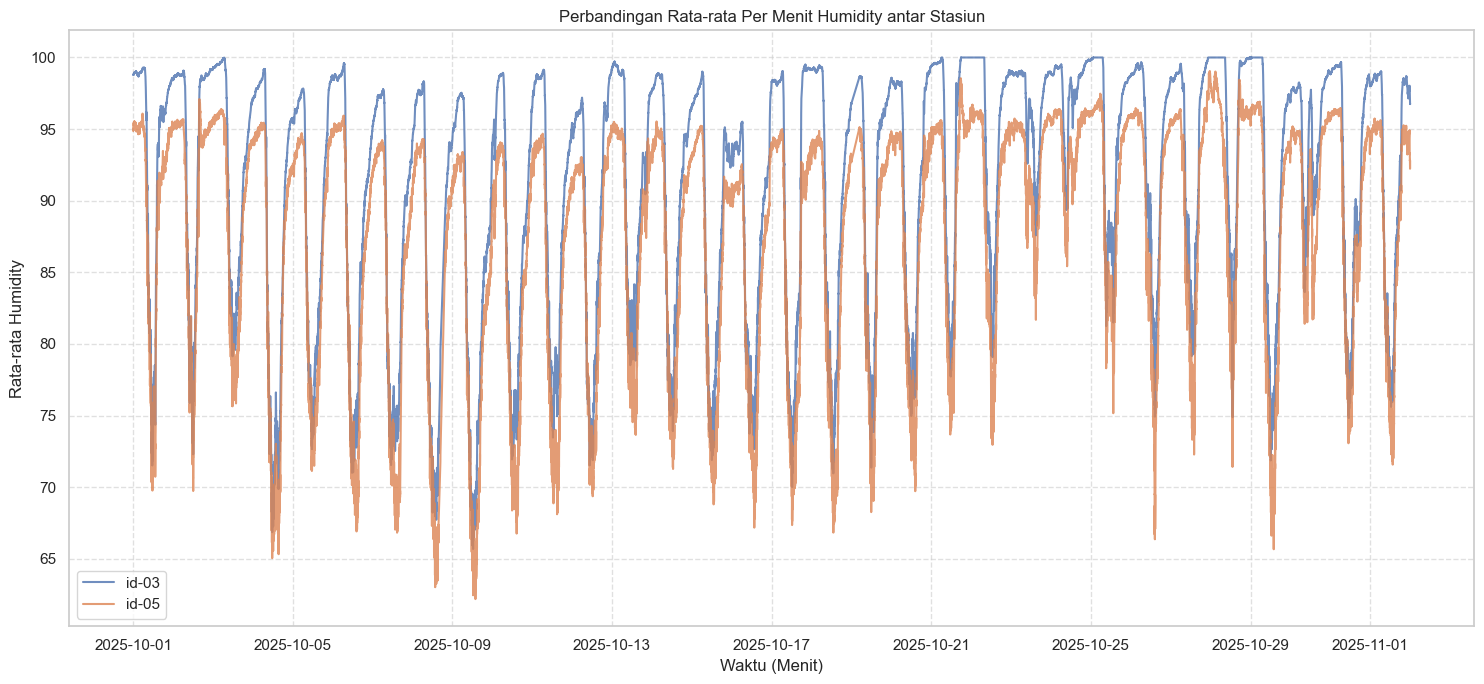

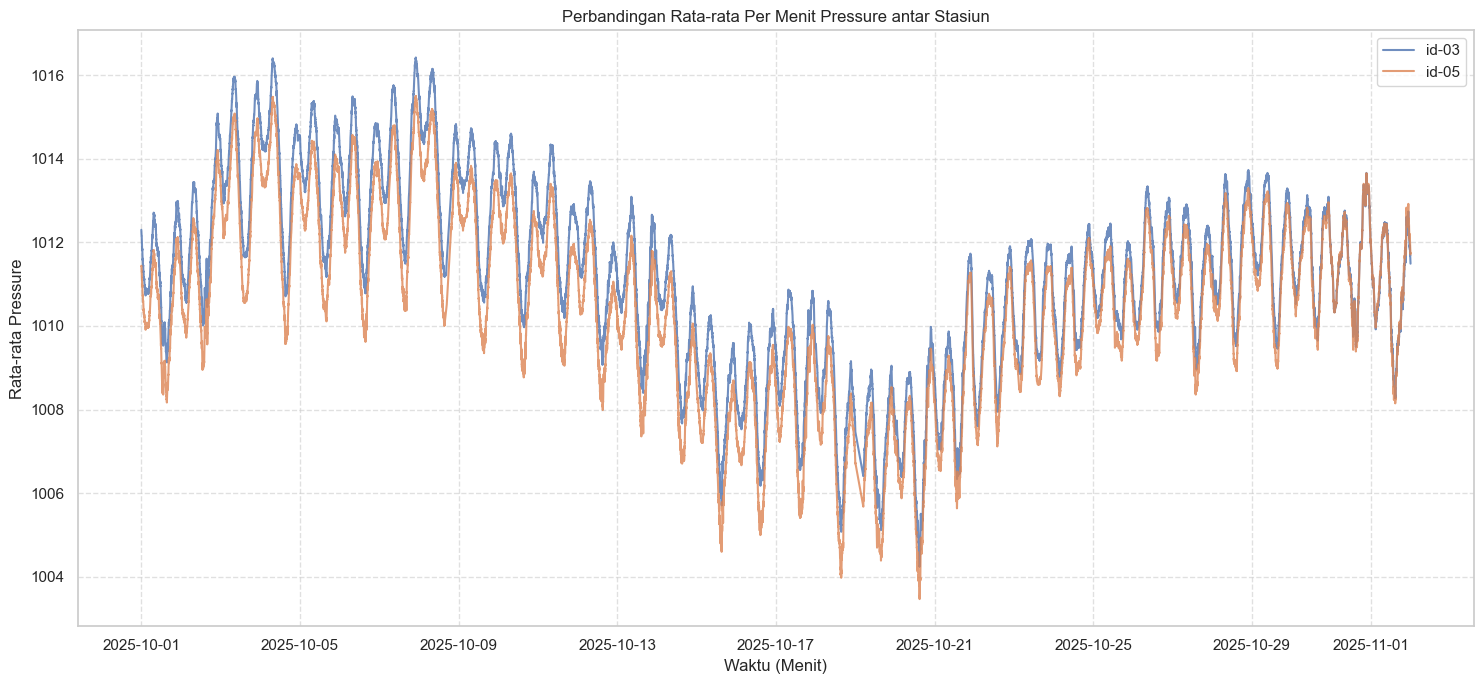

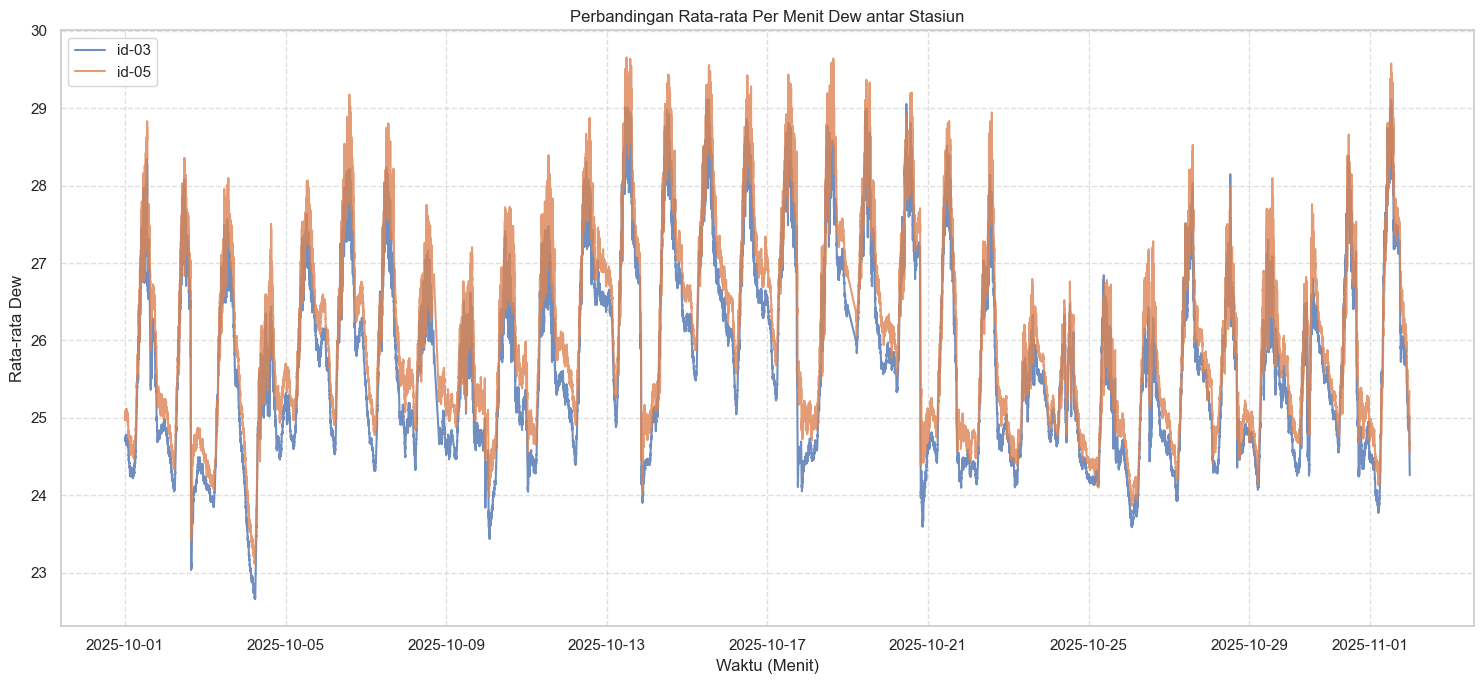

Peringatan: Kolom 'rainrate' tidak ada di stasiun id-03. Dilewati.


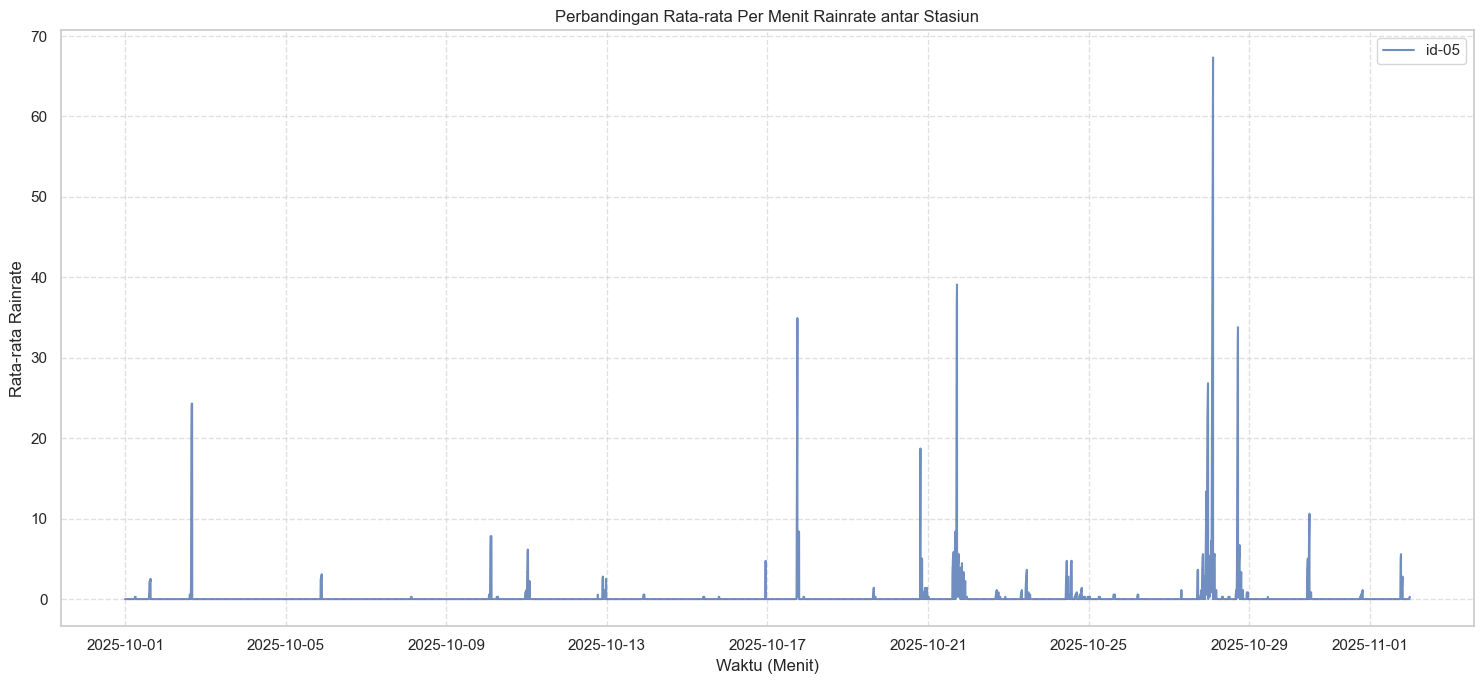

Menampilkan plot perbandingan per jam...


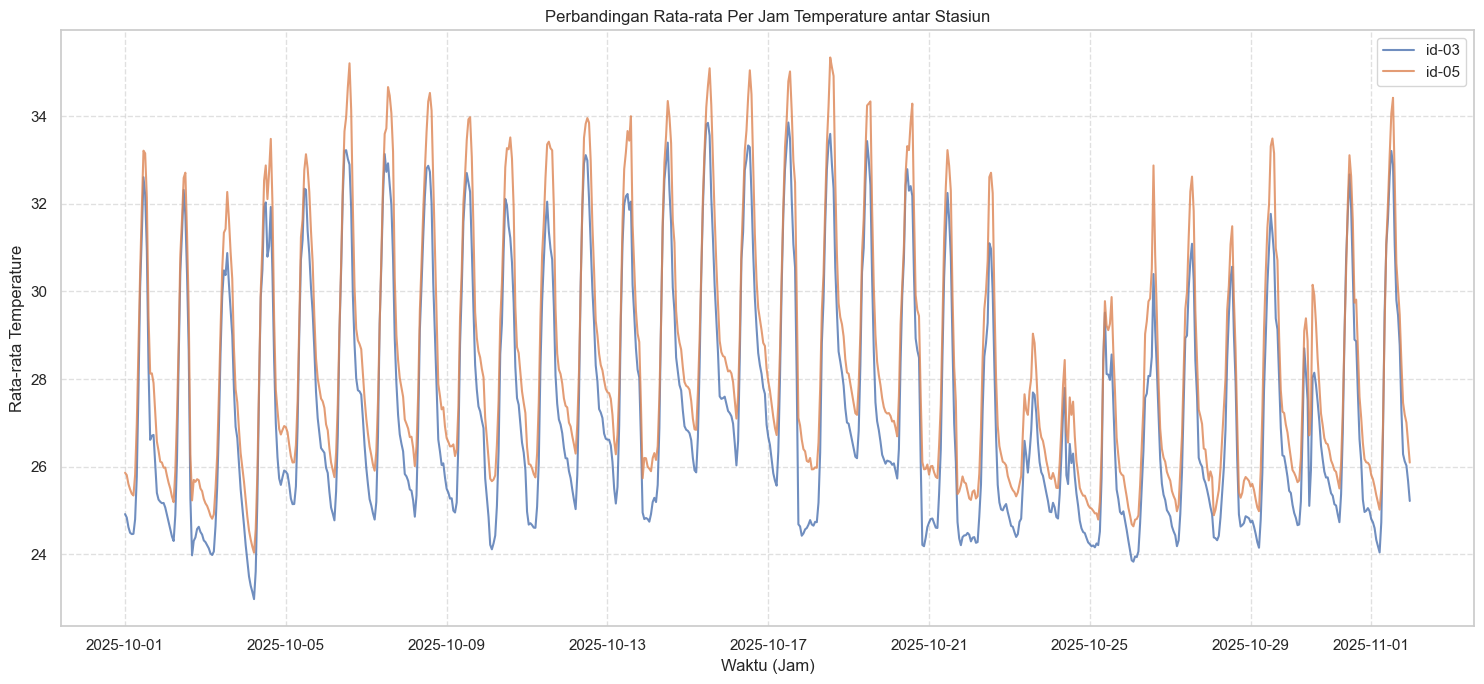

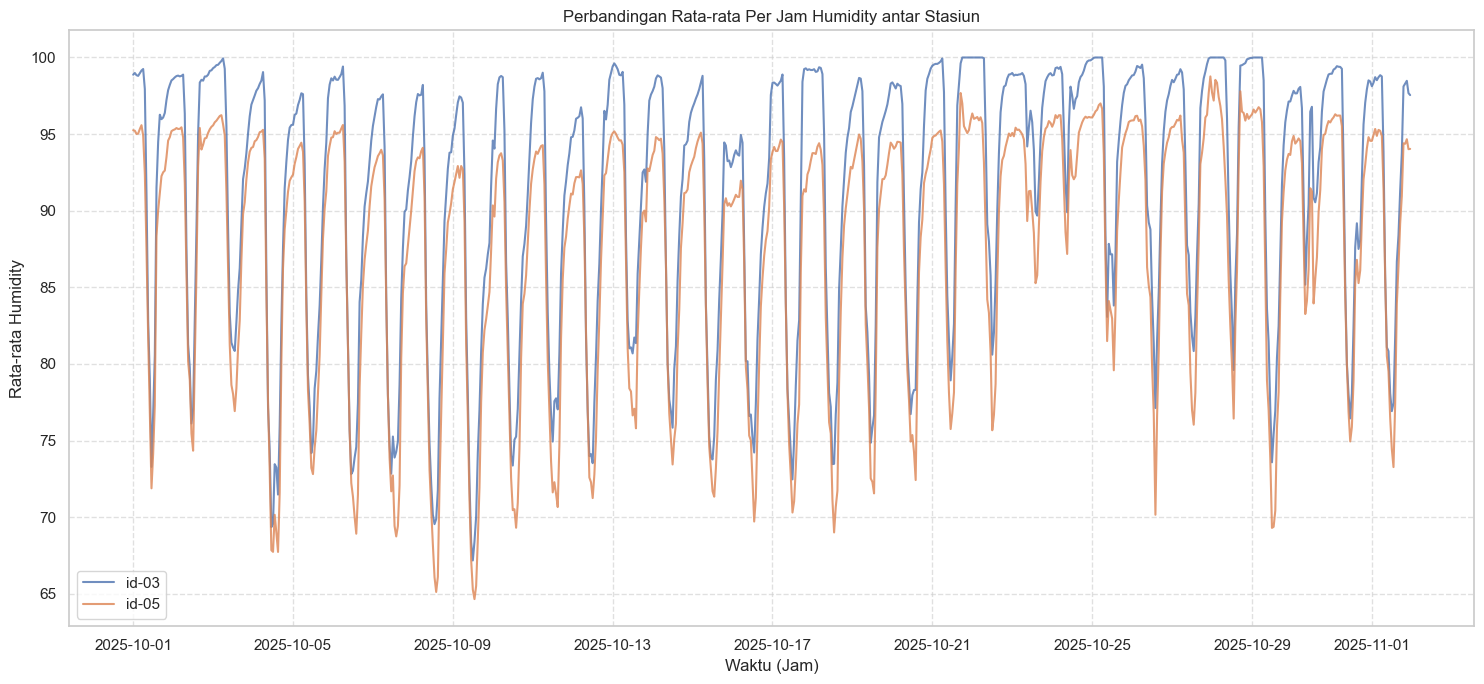

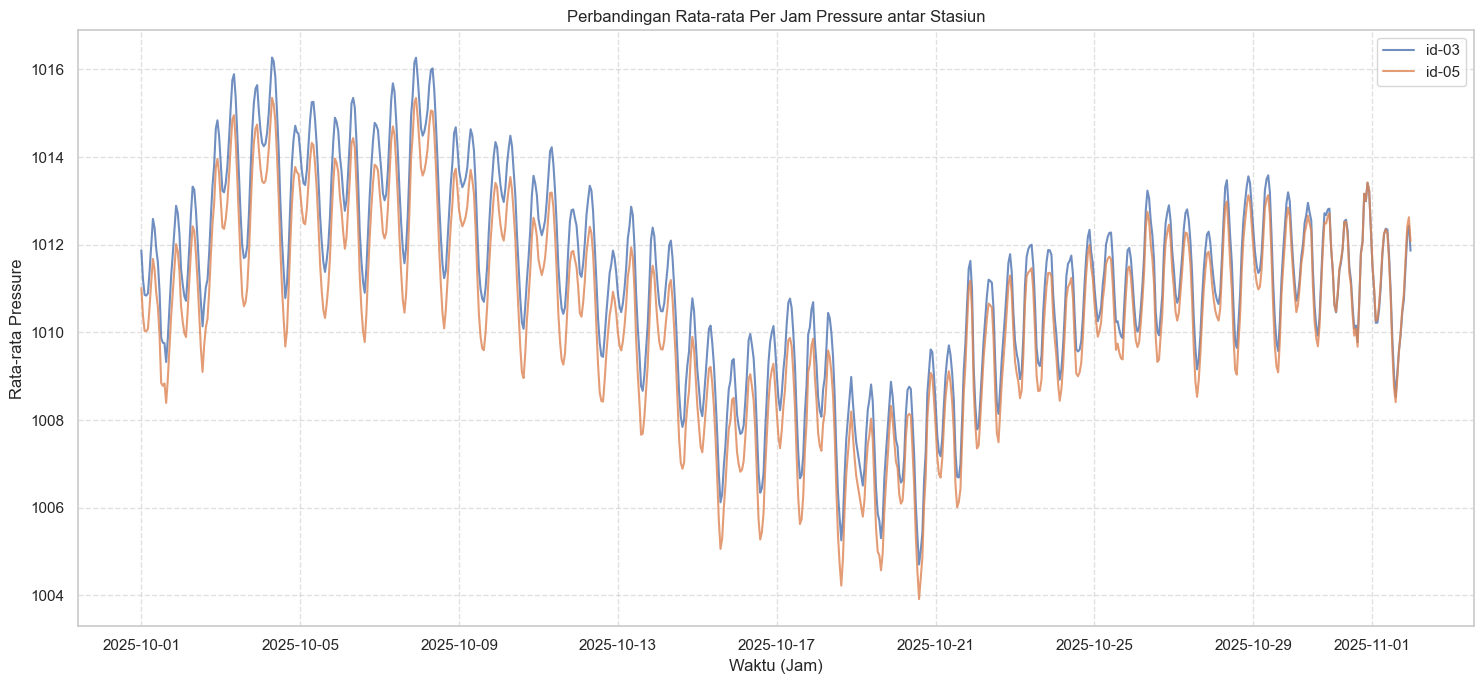

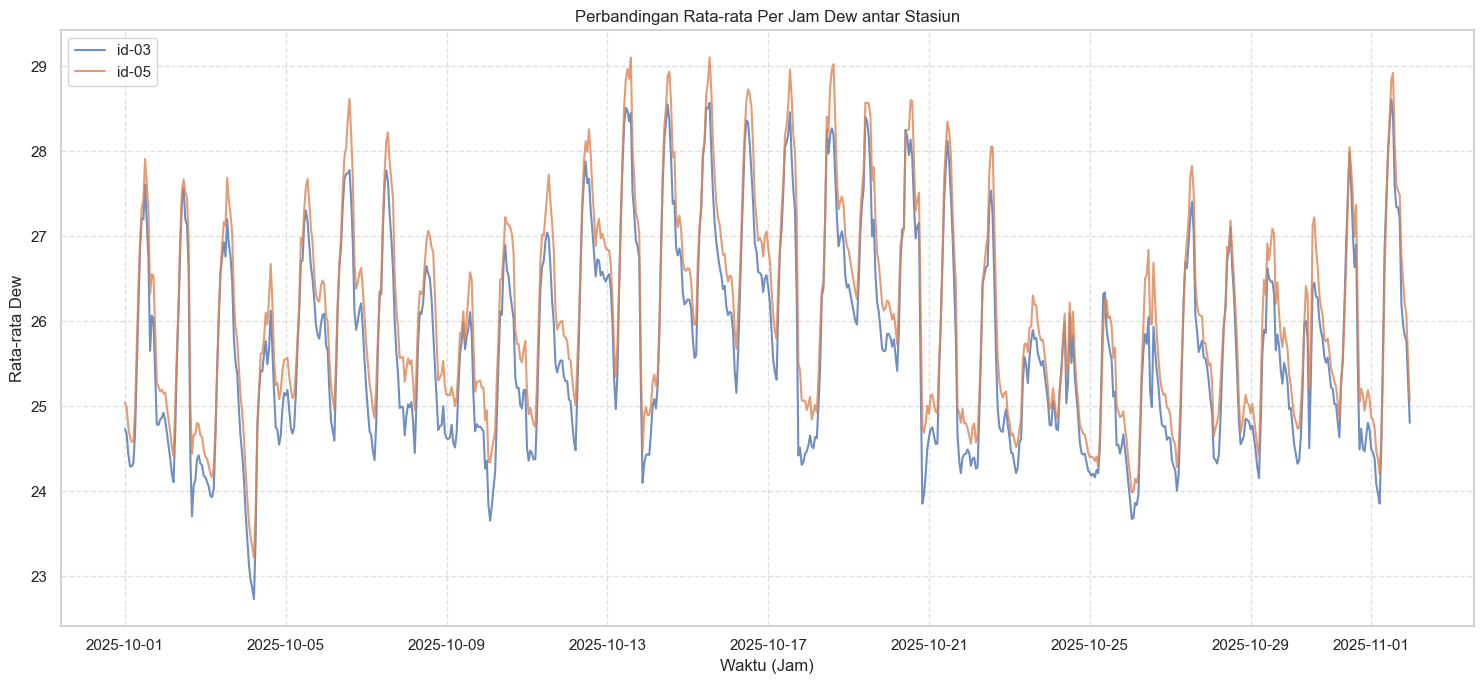

Peringatan: Kolom 'rainrate' tidak ada di stasiun id-03. Dilewati.


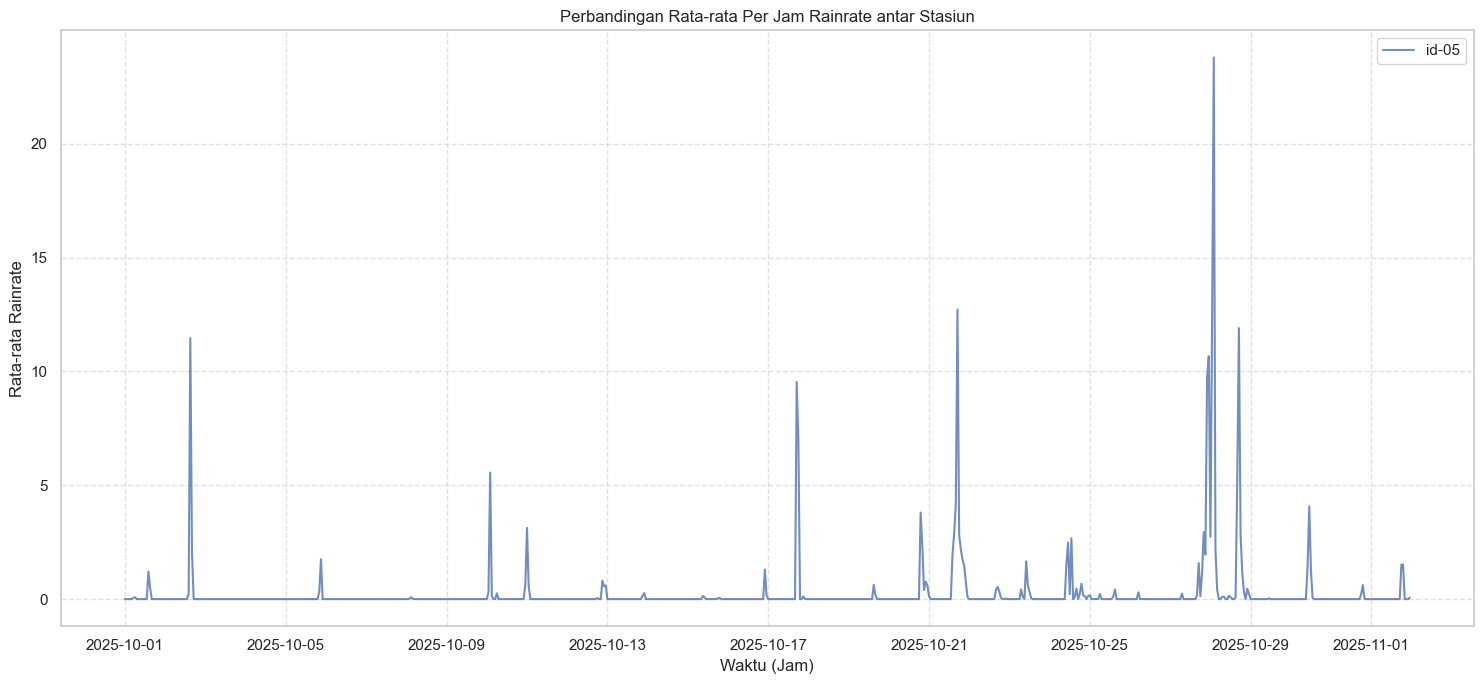


Menampilkan plot perbandingan per hari...


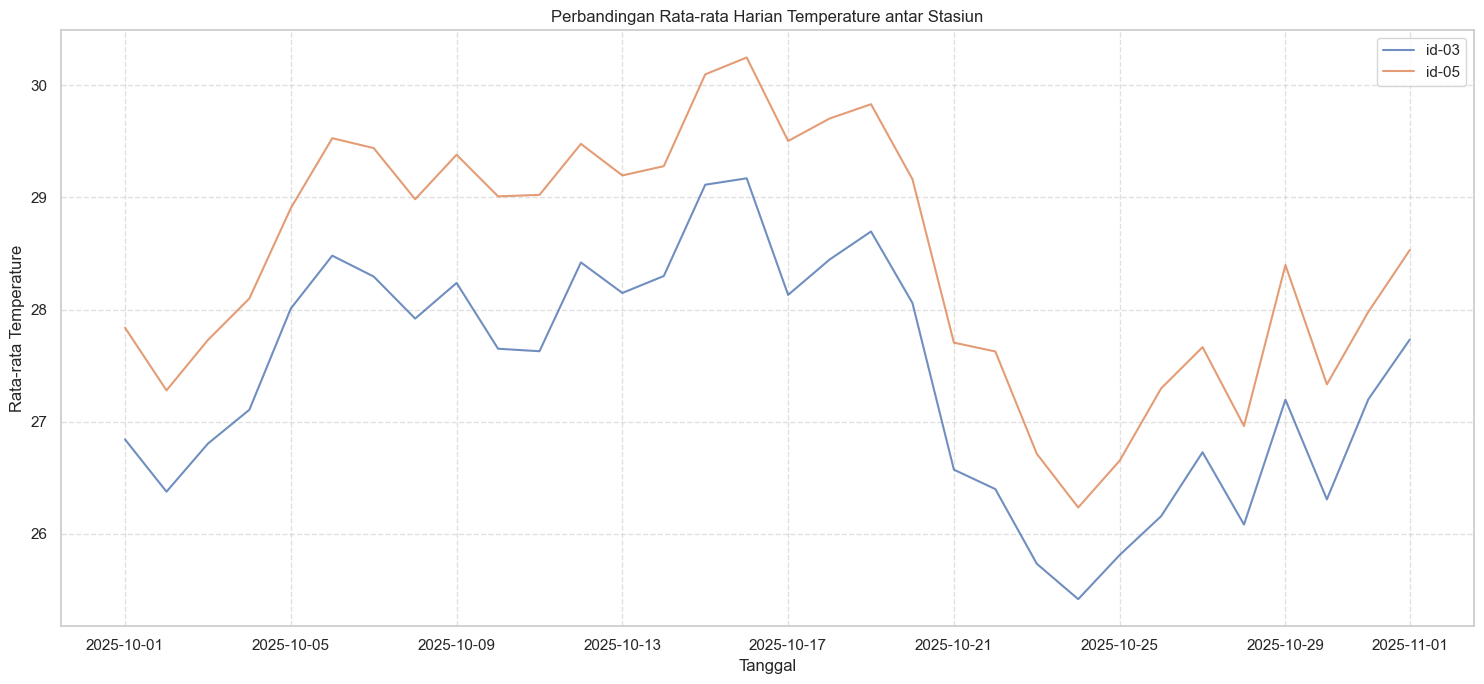

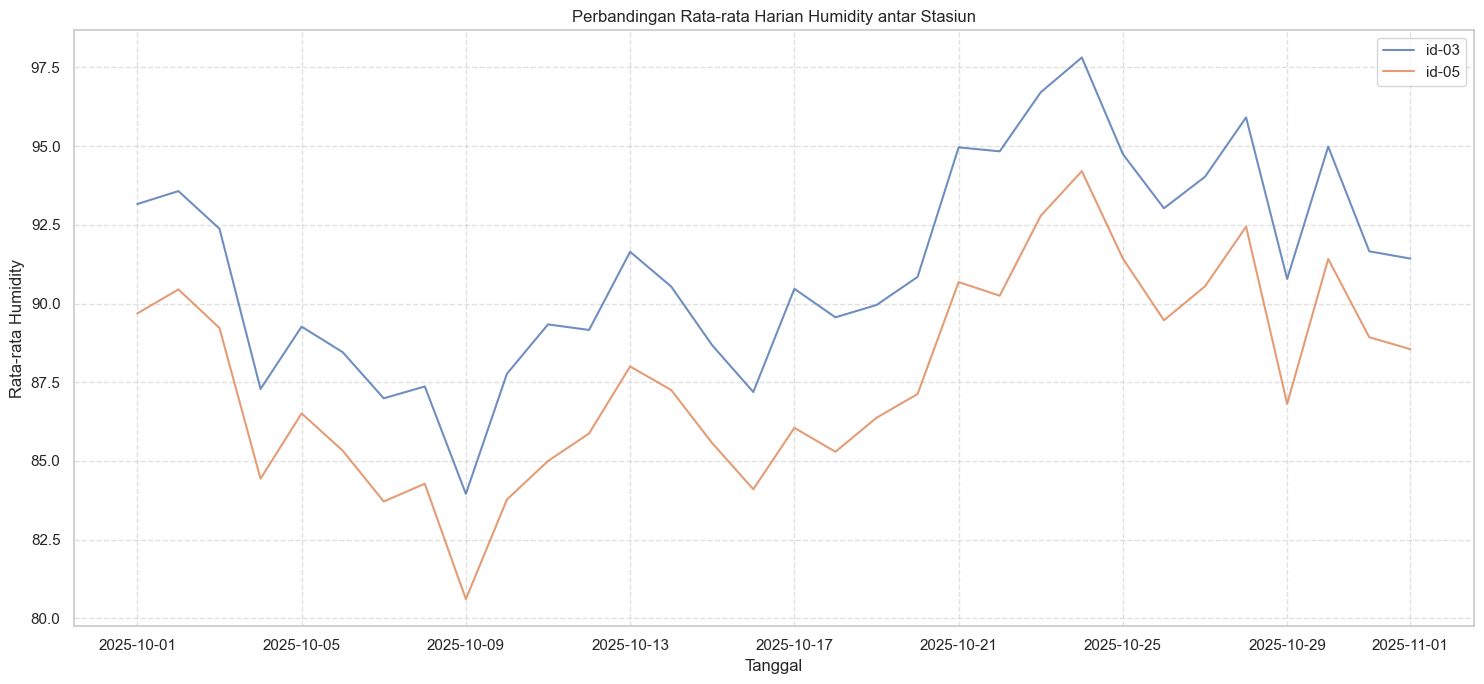

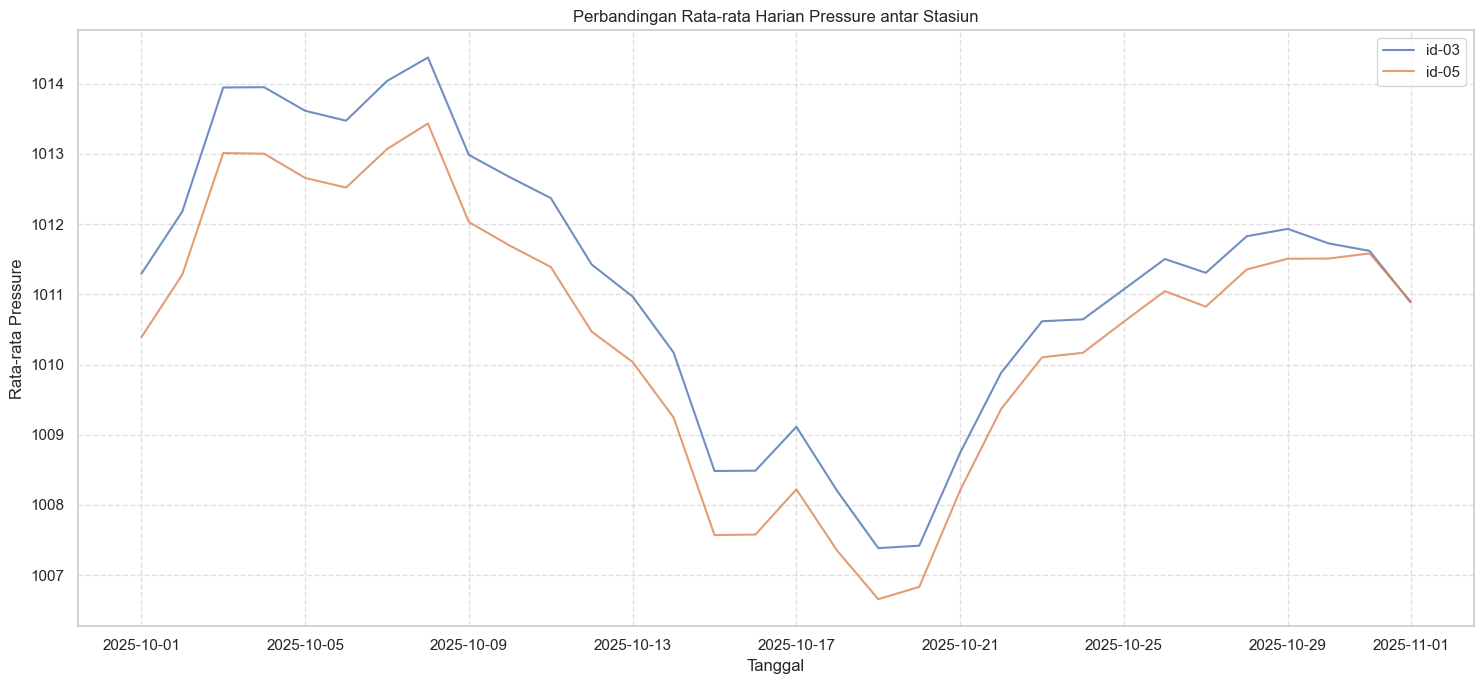

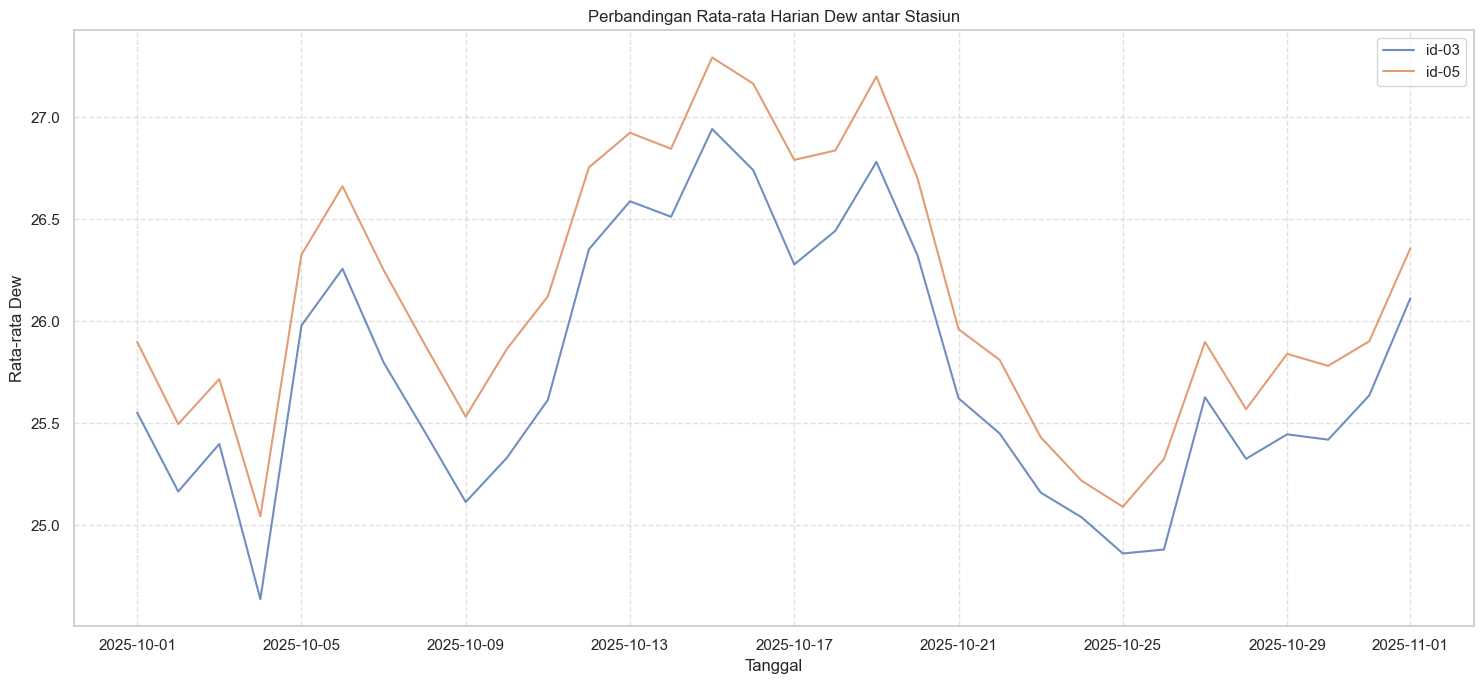

In [17]:
# Asumsi Anda sudah memiliki dictionary 'weather_dataframes'
print("Menampilkan plot perbandingan per menit...")
plot_station_trends(weather_dataframes, 'temperature', freq='min')
plot_station_trends(weather_dataframes, 'humidity', freq='min')
plot_station_trends(weather_dataframes, 'pressure', freq='min')
plot_station_trends(weather_dataframes, 'dew', freq='min')
plot_station_trends(weather_dataframes, 'rainrate', freq='min')
# --- 1. Membuat Plot Rata-rata PER JAM ---
# Cukup atur freq='h'
print("Menampilkan plot perbandingan per jam...")
plot_station_trends(weather_dataframes, 'temperature', freq='h')
plot_station_trends(weather_dataframes, 'humidity', freq='h')
plot_station_trends(weather_dataframes, 'pressure', freq='h')
plot_station_trends(weather_dataframes, 'dew', freq='h')
plot_station_trends(weather_dataframes, 'rainrate', freq='h')


# --- 2. Membuat Plot Rata-rata PER HARI ---
# Gunakan nilai default freq='d' atau tulis secara eksplisit
print("\nMenampilkan plot perbandingan per hari...")
plot_station_trends(weather_dataframes, 'temperature', freq='d')
plot_station_trends(weather_dataframes, 'humidity', freq='d')
plot_station_trends(weather_dataframes, 'pressure', freq='d')
plot_station_trends(weather_dataframes, 'dew', freq='d')

In [18]:
# Perhitungan curah hujan harian dan suhu rata-rata untuk stasiun 'id-05' (cuaca3)
# Sesuai permintaan, logika berikut akan:
# 1. Mencari nilai 'rainrate' maksimum untuk setiap jam.
# 2. Menjumlahkan nilai-nilai maksimum per jam tersebut untuk mendapatkan total harian.
# 3. Menghitung suhu rata-rata harian.

# Salin dataframe untuk menghindari perubahan pada data asli
df_hujan = cuaca3.copy()

# Atur 'timestamp' sebagai indeks untuk mempermudah operasi time series
df_hujan.set_index('timestamp', inplace=True)

df_hujan.head(10)

,dew,humidity,pressure,rainfall,rainrate,temperature,volt,hour,minute,day,week,month,year
timestamp,,,,,,,,,,,,,
2025-10-01 00:00:27+07:00,25.00029,94.89647,1011.43,6.7056,0.0,25.88388,3.93750,0,0,1,40,10,2025
2025-10-01 00:01:27+07:00,24.99310,94.93080,1011.44,6.7056,0.0,25.87053,3.93250,0,1,1,40,10,2025
2025-10-01 00:02:27+07:00,25.01143,94.95941,1011.44,6.7056,0.0,25.88388,3.93625,0,2,1,40,10,2025
2025-10-01 00:03:27+07:00,25.01032,95.02808,1011.40,6.7056,0.0,25.87053,3.93625,0,3,1,40,10,2025
2025-10-01 00:04:27+07:00,24.98992,94.97276,1011.40,6.7056,0.0,25.85985,3.95125,0,4,1,40,10,2025
2025-10-01 00:05:27+07:00,24.97506,94.88884,1011.34,6.7056,0.0,25.85985,3.96125,0,5,1,40,10,2025
2025-10-01 00:06:27+07:00,24.99330,94.99184,1011.35,6.7056,0.0,25.85985,3.93750,0,6,1,40,10,2025
2025-10-01 00:07:27+07:00,24.96764,94.95178,1011.35,6.7056,0.0,25.84116,3.93250,0,7,1,40,10,2025
2025-10-01 00:08:27+07:00,24.97603,94.98421,1011.35,6.7056,0.0,25.84383,3.94000,0,8,1,40,10,2025


--- Data Harian Terolah (Final) ---
                           curah_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                              
2025-10-01 07:00:00+07:00       4.7498  27.840925   34.38354   25.12817
2025-10-02 07:00:00+07:00      49.1744  27.110260   33.48096   24.27367
2025-10-03 07:00:00+07:00       0.0000  27.583775   32.58640   23.96391
2025-10-04 07:00:00+07:00       0.0000  28.650349   34.12985   25.12016
2025-10-05 07:00:00+07:00       5.5880  28.872393   33.44892   25.72366
2025-10-06 07:00:00+07:00       0.0000  29.553233   35.63325   25.85451
2025-10-07 07:00:00+07:00       0.5588  29.489046   35.01907   25.92393
2025-10-08 07:00:00+07:00       0.0000  29.091828   35.13123   26.10017
2025-10-09 07:00:00+07:00      16.4846  29.124297   34.45296   25.59548
2025-10-10 07:00:00+07:00       9.4996  29.013238   34.02571   25.68360
2025-10-11 07:00:00+07:00       0.0000  29.253167   33.77737   26.21767
2025-10-12 07:00:00+07:00   

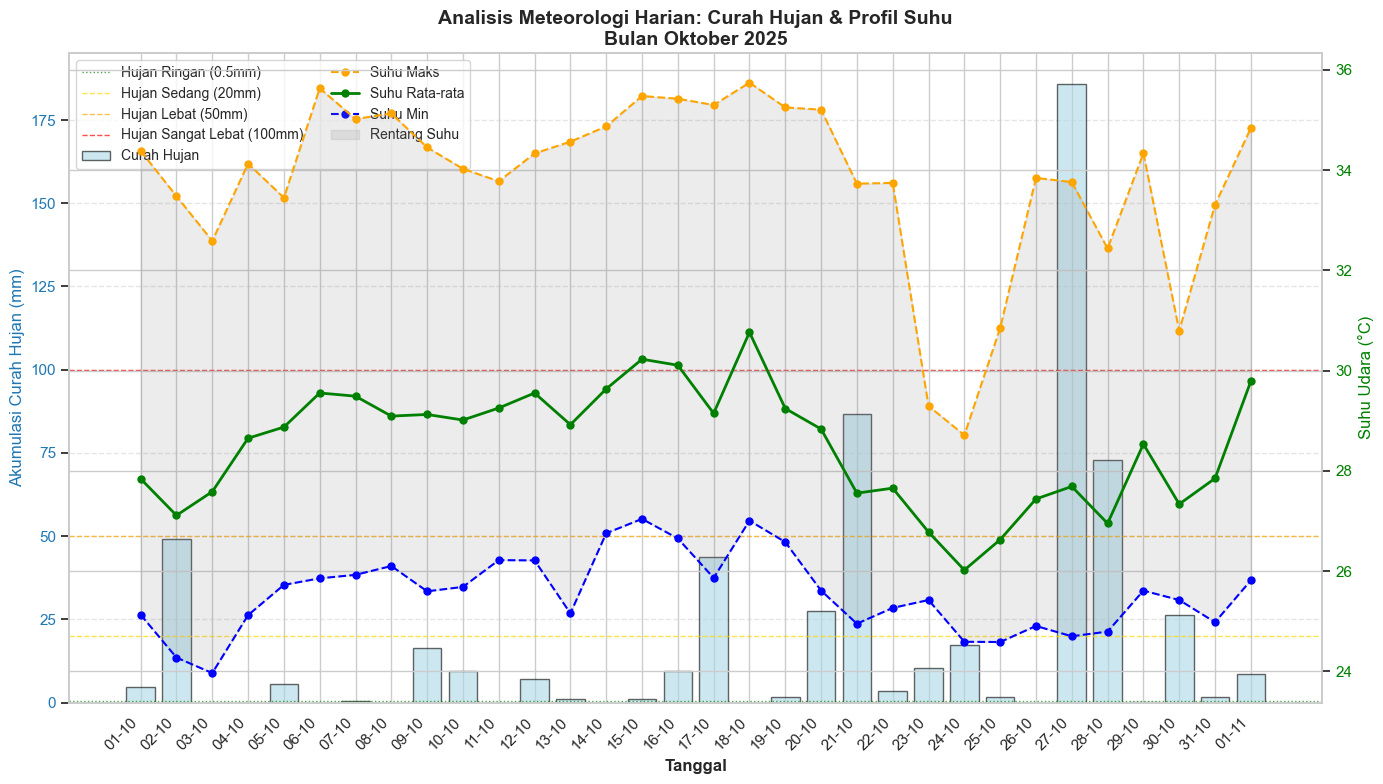

In [23]:
# Langkah 1: Resample data untuk mendapatkan nilai 'rainrate' maksimum per jam.
max_per_jam = df_hujan['rainrate'].tz_convert('UTC').resample('h').max()

# Langkah 2: Resample harian (cut-off 00:00 UTC / 07:00 WIB)
curah_hujan_harian = max_per_jam.resample('d').sum()

# Langkah 3: Hitung statistik suhu harian
# Menggunakan UTC agar sinkron dengan periode hujan
suhu_data_utc = df_hujan['temperature'].tz_convert('UTC')
suhu_rata_harian = suhu_data_utc.resample('d').mean()
suhu_maks_harian = suhu_data_utc.resample('d').max()
suhu_mini_harian = suhu_data_utc.resample('d').min()

# Gabungkan ke DataFrame
df_harian = pd.DataFrame({
    'curah_hujan': curah_hujan_harian,
    'rata_suhu': suhu_rata_harian,
    'suhu_maks': suhu_maks_harian,
    'suhu_mini': suhu_mini_harian
})

# Handling NaN
df_harian['curah_hujan'] = df_harian['curah_hujan'].fillna(0)
df_harian['rata_suhu'] = df_harian['rata_suhu'].interpolate(method='linear')
df_harian['suhu_maks'] = df_harian['suhu_maks'].interpolate(method='linear')
df_harian['suhu_mini'] = df_harian['suhu_mini'].interpolate(method='linear')

# Kembalikan index ke WIB
df_harian = df_harian.tz_convert('Asia/Jakarta')

# --- FILTER TANGGAL AGAR RAPI ---
# Menggunakan start_readable_date dan end_readable_date dari input pengguna
# Format asumsi: "DD-MM-YYYY HH:MM:SS"
start_ts = pd.to_datetime(start_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').floor('D')
end_ts = pd.to_datetime(end_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').ceil('D')

# Potong data yang di luar rentang
df_harian = df_harian.loc[(df_harian.index >= start_ts) & (df_harian.index < end_ts)]

print("--- Data Harian Terolah (Final) ---")
print(df_harian)
print("\n" + "="*50 + "\n")

# --- VISUALISASI BARU ---

fig, ax1 = plt.subplots(figsize=(14, 8))

# 1. Plot Curah Hujan (Bar chart) di ax1
# Gunakan format tanggal string untuk sumbu X agar rapi
date_labels = df_harian.index.strftime('%d-%m') 
ax1.bar(date_labels, df_harian['curah_hujan'], color='lightblue', edgecolor='black', label='Curah Hujan', alpha=0.6)

ax1.set_xlabel('Tanggal', fontsize=12, fontweight='bold')
ax1.set_ylabel('Akumulasi Curah Hujan (mm)', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Memiringkan label tanggal agar tidak tumpang tindih
plt.xticks(rotation=45, ha='right')

# Garis batas kategori hujan (BMKG)
ax1.axhline(y=0.5, color='green', linestyle=':', linewidth=1, alpha=0.7, label='Hujan Ringan (0.5mm)')
ax1.axhline(y=20, color='gold', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sedang (20mm)')
ax1.axhline(y=50, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Lebat (50mm)')
ax1.axhline(y=100, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Hujan Sangat Lebat (100mm)')

# 2. Membuat secondary y-axis (ax2) untuk Suhu
ax2 = ax1.twinx()

# Kita plot garis menggunakan range(len) agar pas di tengah bar chart
x_axis = range(len(df_harian))

# A. Plot Suhu Maksimum (Jingga)
ax2.plot(x_axis, df_harian['suhu_maks'], color='orange', linestyle='--', marker='o', markersize=5, label='Suhu Maks')

# B. Plot Suhu Rata-rata (Hijau)
ax2.plot(x_axis, df_harian['rata_suhu'], color='green', linewidth=2, marker='o', markersize=5, label='Suhu Rata-rata')

# C. Plot Suhu Minimum (Biru)
ax2.plot(x_axis, df_harian['suhu_mini'], color='blue', linestyle='--', marker='o', markersize=5, label='Suhu Min')

# D. Arsiran Rentang Suhu (Diurnal Range) - Opsional tapi Bagus
# Memberikan efek visual rentang suhu hari itu
ax2.fill_between(x_axis, df_harian['suhu_mini'], df_harian['suhu_maks'], color='gray', alpha=0.15, label='Rentang Suhu')

ax2.set_ylabel('Suhu Udara (°C)', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Judul dan Grid
ax1.set_title('Analisis Meteorologi Harian: Curah Hujan & Profil Suhu\nBulan Oktober 2025', fontsize=14, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Menggabungkan Legend dari kedua axis agar rapi
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Taruh legend di luar plot atau di posisi kosong
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize='small', frameon=True)

plt.tight_layout()

# --- Menyimpan Plot ---
output_folder = 'plots'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Ambil tanggal awal dan akhir dari index dataframe langsung (lebih aman)
tgl_awal = df_harian.index[0].strftime('%Y-%m-%d')
tgl_akhir = df_harian.index[-1].strftime('%Y-%m-%d')
filename = f"Meteo_Chart_id-05_{tgl_awal}_sd_{tgl_akhir}.png"
filepath = os.path.join(output_folder, filename)

plt.savefig(filepath, dpi=300)
print(f"Grafik berhasil disimpan di: {filepath}")

plt.show()

In [20]:
df_harian.tail(10)

,curah_hujan,rata_suhu,suhu_maks,suhu_mini
timestamp,,,,
2025-10-23 07:00:00+07:00,10.3378,26.778295,29.29389,25.42191
2025-10-24 07:00:00+07:00,17.3228,26.019137,28.71175,24.58877
2025-10-25 07:00:00+07:00,1.6764,26.626529,30.84802,24.58343
2025-10-26 07:00:00+07:00,0.0000,27.437962,33.84413,24.90387
2025-10-27 07:00:00+07:00,185.8010,27.687404,33.76135,24.69825
2025-10-28 07:00:00+07:00,72.9234,26.950175,32.43687,24.79172
2025-10-29 07:00:00+07:00,0.2794,28.533425,34.33547,25.60883
2025-10-30 07:00:00+07:00,26.2636,27.335630,30.79462,25.42191
2025-10-31 07:00:00+07:00,1.6764,27.848572,33.31007,24.97864
